# Исследование данных о поездках на арендованных самокатах

Сервис GoFast предоставляет услуги аренды самокатов. Аренда происходит через мобильное приложение, и услугой можно воспользоваться с подпиской, так и без неё. Различия заключаются в способе оплаты: в случае с подпиской оплачивается абонентская плата и время поездки; в случае без подписки оплачивается старт и время поездки.

Есть три таблицы с данными о поездках на арендованных самокатах: таблица с данными о пользователях, о поездках и о типах подписки.

## Цели
 - Изучить данные, сформулировать и проверить гипотезы для развития бизнеса.



## План работы
 - Загрузить таблицы с данными и изучить их
 - Проверить наличие пропусков, выбросов и дубликатов и устранить их, если они есть
 - Подготовить данные для проверки гипотез
 - Проверить гипотезы
 - Сделать вывод, являются ли пользователи с подпиской более выгодными для бизнеса или нет


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
from math import factorial
from matplotlib import pyplot as plt

#### Шаг 1. Загрузка данных

In [ ]:
try:
    users_data = pd.read_csv('/datasets/users_go.csv')
    rides_data = pd.read_csv('/datasets/rides_go.csv')
    subscription_data = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    print('Не удалось открыть файл')

In [ ]:
display(users_data.head())

users_data.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
display(rides_data.head())

rides_data.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [ ]:
display(subscription_data.head())

subscription_data.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Дано три таблицы с данными: users_data, rides_data, subscription_data.

В датафрейме users_data находятся данные о возрасте, городе и типе подписки пользователей, а также их id и имена. Всего в users_data 1565 строк, данные об id пользователей и их возрасте типа int.

Во втором датафрейме rides_data видим данные о расстоянии, пройденном за одну поездку, времени одной поездки и дате поездки, и также id пользователя, состоит из 18068 строк. Данные о расстоянии и времени поездки типа float, дата типа object.

В третьем датафрейме subscription_data данные о типе подписки  ценах на старт, абонентскую плату и минуту поездки. Цена за начало поездки для пользователей с подпиской принята за ноль, то же самое с ценой за абонентскую плату. Состоит из двух строк.

#### Шаг 2. Предобработка данных

Приведём столбец date в датафрейме rides_data к типу даты pandas и добавим новый столбец с номером месяца.

In [ ]:
rides_data['date'] = pd.to_datetime(rides_data['date'],format='%Y-%m-%dT')

In [ ]:
rides_data['month'] = rides_data['date'].dt.month
print(rides_data.head())

   user_id     distance   duration       date  month
0        1  4409.919140  25.599769 2021-01-01      1
1        1  2617.592153  15.816871 2021-01-18      1
2        1   754.159807   6.232113 2021-04-20      4
3        1  2694.783254  18.511000 2021-08-11      8
4        1  4028.687306  26.265803 2021-08-28      8


Проверим, за какой период данные.

In [ ]:
print(rides_data['date'].dt.year.unique())

print(rides_data['date'].dt.month.sort_values().unique())

[2021]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


Данные собраны за весь 2021-ый год.

Проверим данные на наличие пропусков и дубликатов.

In [ ]:
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [ ]:
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [ ]:
subscription_data.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков ни в каком датафрейме нет.

In [ ]:
users_data['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [ ]:
users_data['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Дубликатов нет.

In [ ]:
users_data['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534])

In [ ]:
users_data.info()
users_data['user_id'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


array([   1,    2,    3, ..., 1532, 1533, 1534])

In [ ]:
print(users_data.duplicated().sum())

display(users_data[users_data['user_id'].duplicated()] )

31


,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [ ]:
users_data = users_data.drop_duplicates().reset_index(drop=True)

print(users_data.duplicated().sum())

0


In [ ]:
print(rides_data.duplicated().sum())

0


In [ ]:
print(subscription_data.duplicated().sum())

0


В ходе предобработки данных были выявлены и удалены явные дубликаты. Неявных дубликатов и пропущенных значений не было найдено ни в одной таблице с данными.

#### Шаг 3. Исследовательский анализ данных

In [ ]:
users_data['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

<AxesSubplot:>

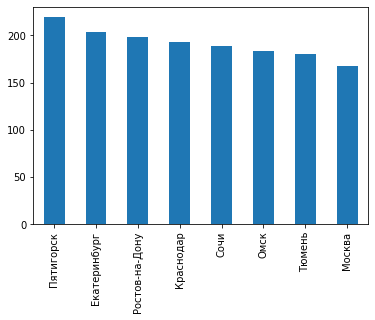

In [ ]:
users_data['city'].value_counts().plot.bar()

Данные есть о восьми городах.

В Пятигорске чаще всего арендуют самокаты, реже всего в Москве из данного набора городов.

Соотношение пользователей с подпиской и без подписки: 1.1945636623748213


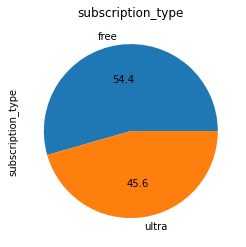

In [ ]:
users_data['subscription_type'].value_counts().plot(kind='pie',autopct='%.1f')
plt.title('subscription_type')

print('Соотношение пользователей с подпиской и без подписки:',
      users_data[users_data['subscription_type']=='free']['subscription_type'].count()
      / users_data[users_data['subscription_type']=='ultra']['subscription_type'].count())

Text(0.5, 0, 'age')

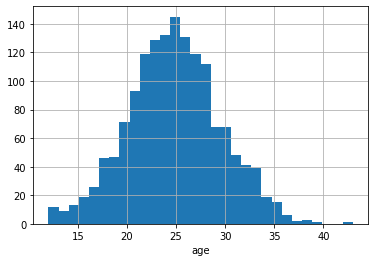

In [ ]:
users_data['age'].hist(bins=30)
plt.xlabel('age')

Возраст пользователей удовлетворяет нормальному распределению, никаких выбросов нет.

Видим, что больше всего пользователей, около 140, в возрасте 25 лет.

Text(0.5, 0, 'distance')

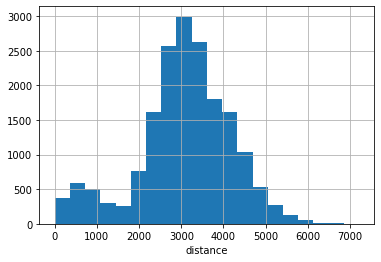

In [ ]:
rides_data['distance'].hist(bins=20)
plt.xlabel('distance')

Данные о пройденном расстоянии удовлетворяют нормальному распределению. Больше всего поездок, около 3000, расстоянием в 3 километра. Однако есть небольшой пик на примерно 500 метрах, таких поездок около 500.

Text(0.5, 0, 'duration')

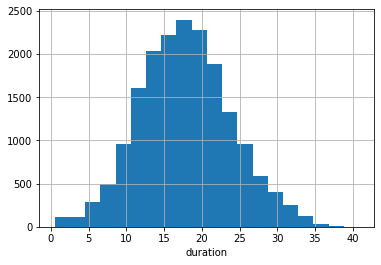

In [ ]:
rides_data['duration'].hist(bins=20)
plt.xlabel('duration')

Выбросов нет, чаще всего, в примерно 2300 случаев, длительность поездки составляет от 15 до 20 минут.

Таким образом, больше всего пользователей в возрасте 25 лет, они проезжают примерно 3 километра, и занимает поездка от 15 до 20 минут. Пользователей без подписки чуть больше, чем пользователей с подпиской, примерно в 1.2 раза.

#### Шаг 4. Объединение данных

In [ ]:
data_merged = users_data.merge(rides_data,on='user_id',how='left')

data = data_merged.merge(subscription_data,on='subscription_type',how='left')

print(data.head(5))

   user_id  name  age    city subscription_type     distance   duration  \
0        1  Кира   22  Тюмень             ultra  4409.919140  25.599769   
1        1  Кира   22  Тюмень             ultra  2617.592153  15.816871   
2        1  Кира   22  Тюмень             ultra   754.159807   6.232113   
3        1  Кира   22  Тюмень             ultra  2694.783254  18.511000   
4        1  Кира   22  Тюмень             ultra  4028.687306  26.265803   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1             6                 0               199  
2 2021-04-20      4             6                 0               199  
3 2021-08-11      8             6                 0               199  
4 2021-08-28      8             6                 0               199  


In [ ]:
data_free = data[data['subscription_type'] == 'free']

display(data_free.head())

data_ultra = data[data['subscription_type'] == 'ultra']

display(data_ultra.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Text(0.5, 1.0, 'No subscription')

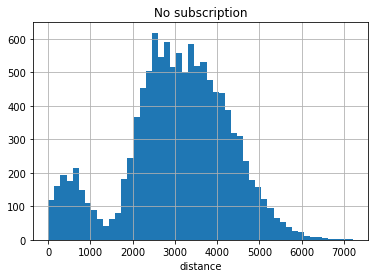

In [ ]:
data_free['distance'].hist(bins=50)
plt.xlabel('distance')
plt.title('No subscription')

Text(0.5, 1.0, 'Subscription')

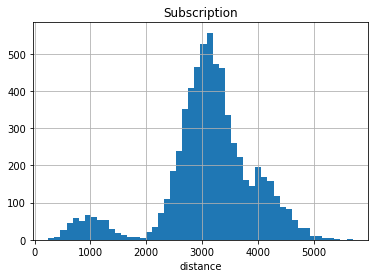

In [ ]:
data_ultra['distance'].hist(bins=50)
plt.xlabel('distance')
plt.title('Subscription')

В случае поездок пользователей без подписки и с ней наблюдается пик около 500 метров, однако в первом случае он выраженнее.

В основном, в обоих случаях пользователи проезжают обычно примерно 3 километра, однако разброс для пользователей без подписки больше.

Text(0.5, 1.0, 'No subscription')

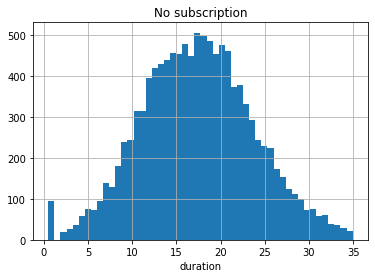

In [ ]:
data_free['duration'].hist(bins=50)
plt.xlabel('duration')
plt.title('No subscription')

Text(0.5, 1.0, 'Subscription')

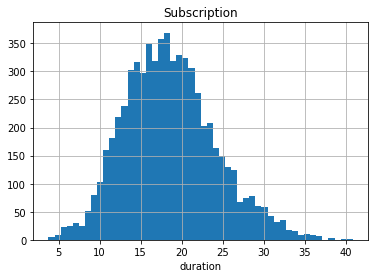

In [ ]:
data_ultra['duration'].hist(bins=50)
plt.xlabel('duration')
plt.title('Subscription')

Пользователи как с подпиской, так и без неё, тратят на поездки в основном от 15 до 20 минут. Однако у данных для пользователей без подписки больше разброс, и наблюдается небольшой пик около нуля.

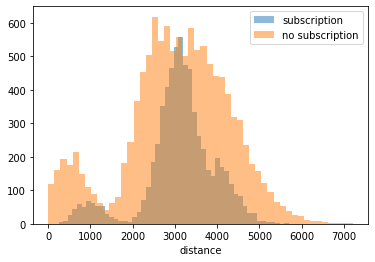

In [ ]:
plt.hist(data_ultra['distance'], bins=50,alpha=0.5,label='subscription')
plt.hist(data_free['distance'],bins=50,alpha=0.5,label='no subscription' )
plt.legend(loc='upper right')
plt.xlabel('distance')
plt.show()

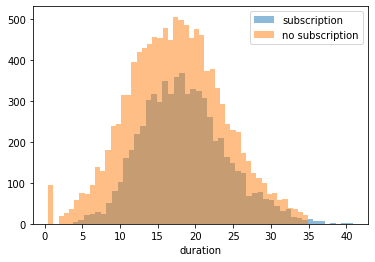

In [ ]:
plt.hist(data_ultra['duration'], bins=50,alpha=0.5,label='subscription')
plt.hist(data_free['duration'],bins=50,alpha=0.5,label='no subscription' )
plt.legend(loc='upper right')
plt.xlabel('duration')
plt.show()

#### Шаг 5. Подсчёт выручки

In [ ]:
data['duration']=data['duration'].apply(np.ceil)

data_agg = data.groupby(['user_id','month']).agg({'distance':['sum','count'],'duration':'sum',
                                                  'subscription_type':'first',\
                                                  'minute_price':'first','start_ride_price':'first','subscription_fee':'first'})
data_agg.head()
#data_agg['duration'] = data_agg['duration'].apply(np.ceil)

distance       duration subscription_type minute_price  \
                       sum count      sum             first        first   
user_id month                                                              
1       1      7027.511294     2     42.0             ultra            6   
        4       754.159807     1      7.0             ultra            6   
        8      6723.470560     2     46.0             ultra            6   
        10     5809.911100     2     32.0             ultra            6   
        11     7003.499363     3     56.0             ultra            6   

              start_ride_price subscription_fee  
                         first            first  
user_id month                                    
1       1                    0              199  
        4                    0              199  
        8                    0              199  
        10                   0              199  
        11                   0              199

In [ ]:
# Код ревьюера
data.groupby(['user_id','month']).agg({'distance':['sum','count'],'duration':'sum'}).head()

distance       duration
                       sum count      sum
user_id month                            
1       1      7027.511294     2     42.0
        4       754.159807     1      7.0
        8      6723.470560     2     46.0
        10     5809.911100     2     32.0
        11     7003.499363     3     56.0

In [ ]:
data_agg['income'] = data_agg['minute_price']['first']*data_agg['duration']['sum'] + data_agg['start_ride_price']['first']*data_agg['distance']['count']+data_agg['subscription_fee']['first']

print(data_agg.head())

                  distance       duration subscription_type minute_price  \
                       sum count      sum             first        first   
user_id month                                                              
1       1      7027.511294     2     42.0             ultra            6   
        4       754.159807     1      7.0             ultra            6   
        8      6723.470560     2     46.0             ultra            6   
        10     5809.911100     2     32.0             ultra            6   
        11     7003.499363     3     56.0             ultra            6   

              start_ride_price subscription_fee income  
                         first            first         
user_id month                                           
1       1                    0              199  451.0  
        4                    0              199  241.0  
        8                    0              199  475.0  
        10                   0              199  

In [ ]:
# Код ревьюера
display(data_agg.head(3))
data_agg.groupby(('subscription_type', 'first'))['income'].mean()

distance       duration subscription_type minute_price  \
                       sum count      sum             first        first   
user_id month                                                              
1       1      7027.511294     2     42.0             ultra            6   
        4       754.159807     1      7.0             ultra            6   
        8      6723.470560     2     46.0             ultra            6   

              start_ride_price subscription_fee income  
                         first            first         
user_id month                                           
1       1                    0              199  451.0  
        4                    0              199  241.0  
        8                    0              199  475.0

(subscription_type, first)
free     328.641365
ultra    362.792191
Name: income, dtype: float64

In [ ]:
# Код ревьюера
len(data_agg)

11331

#### Шаг 6. Проверка гипотез

$H_0$: Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки


$H_1$: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки

In [ ]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'],data_free['duration'],alternative='greater')

print(results.pvalue,data_ultra['duration'].mean(),data_free['duration'].mean())

if results.pvalue<alpha:
    print('Отвергаем гипотезу, что пользователи тратят одинаковое количество времени на поездки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

1.2804098316645618e-34 18.54198516280583 17.39090929866399
Отвергаем гипотезу, что пользователи тратят одинаковое количество времени на поездки


Средняя продолжительность поездок для пользователей с подпиской больше, поэтому принимаем альтернативную гипотезу.

$H_0$: Расстояние поездки равно оптимальному расстоянию с точки зрения износа самоката.


$H_1$: Расстояние поездки больше оптимального.

In [ ]:
optimal_distance = 3130

results = st.ttest_1samp(data_ultra['distance'],optimal_distance,alternative = 'greater')

print(results.pvalue,data_ultra['distance'].mean())

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

0.9195368847849785 3115.4453880370247
Нет оснований отвергать нулевую гипотезу


Значит, можно считать, что расстояние, которое проезжают пользователи, не превосходит 3130 м.

$H_0$: Помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.


$H_1$: Помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки.

In [ ]:
income_free = data_agg[data_agg[('subscription_fee', 'first')] == 0]['income']
income_ultra = data_agg[data_agg['subscription_fee','first'] != 0]['income']

result = st.ttest_ind(income_ultra,income_free,alternative='greater')
print(result.pvalue,income_free.mean(),income_ultra.mean())

if result.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')


1.8850394384715216e-31 328.6413651073845 362.7921906022502
Отвергаем нулевую гипотезу


По результату теста отвергаем нулевую гипотезу.

Средняя прибыль от пользователей без подписки составляет примерно 328.6 рублей, а от подписчиков - 362.8 рублей.

In [1]:
sample_ultra = data_agg[data_agg[('subscription_fee', 'first')] == 199]['income'] # Массив выручек подписчиков
sample_free = data_agg[data_agg[('subscription_fee', 'first')] == 0]['income'] # Массив выручек пользователей без подписки

NameError: name 'data_agg' is not defined

По результатам теста нельзя говорить, что помесячные выручки совпадают. Причем средняя помесячная цена поездок пользователей с подпиской меньше цены поездок пользователей без подписки.

Чтобы проверить, уменьшилось ли количество обращений в техподдержку после обновления, надо использовать тест для зависимых выборок ttest_rel(). В качестве аргументов передавались бы данные об обращениях до и после обновления.

#### Шаг 7. Распределения

Вывод:

Было проведено исследование по выявлению зависимости прибыли от аренды самокатов от наличия подписки у пользователей.
В ходе исследования были сформулированы следующие гипотезы:

1) Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки
2) Расстояние, которое проезжают пользователи с подпиской равно оптимальному расстоянию с точки зрения износа самоката - 3130 м
3) Помесячная выручка от пользователя с подпиской равна выручке пользователей без подписки

Первую гипотезу не отвергаем, так как средняя продолжительность поездок для пользователей с подпиской 18.5 минут, а без - 17.4, причем вероятность получить равные средние значения на данных много меньше 0.05.

Вторую гипотезу тоже нельзя отвергнуть, так как вероятность получить предполагаемое значение на наших данных примерно 0.9, а наблюдаемое среднее равно 3115.4 м.

Третью гипотезу отвергаем, так как средние значения сильно различаются и вероятность получить одинаковые значения на данных много меньше 0.05.

Также, по результатам исследования было выявлено, что больше всего пользователей в возрасте 25 лет, они проезжают примерно 3 километра, и занимает поездка от 15 до 20 минут. Пользователей без подписки чуть больше, чем пользователей с подпиской, примерно в 1.2 раза.

В заключении, выручка от пользователей с подпиской больше, чем от пользователей без подписки.